In [1]:
import pandas as pd
import numpy as np
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from arch.bootstrap import optimal_block_length, StationaryBootstrap, CircularBlockBootstrap

In [2]:
data = pd.read_csv('data_croped.csv', index_col=0)
tp = pd.read_csv('tp_croped.csv', index_col=0)

# Vérification
assert tp.index.equals(data.index), "Les index ne sont pas alignés"

#### Optionnel : Scaling

In [3]:
# Créer un scaler pour standardiser les données
scaler = MinMaxScaler()

# Appliquer la standardisation aux features
X_scaled = scaler.fit_transform(data)

# Re-créer un DataFrame avec les mêmes colonnes que X
data = pd.DataFrame(X_scaled, columns=data.columns, index=data.index)

Taille de bloc optimale pour StationaryBootstrap : 35.29
Taille de bloc optimale pour CircularBlockBootstrap : 40.40
<class 'pandas.core.frame.DataFrame'>


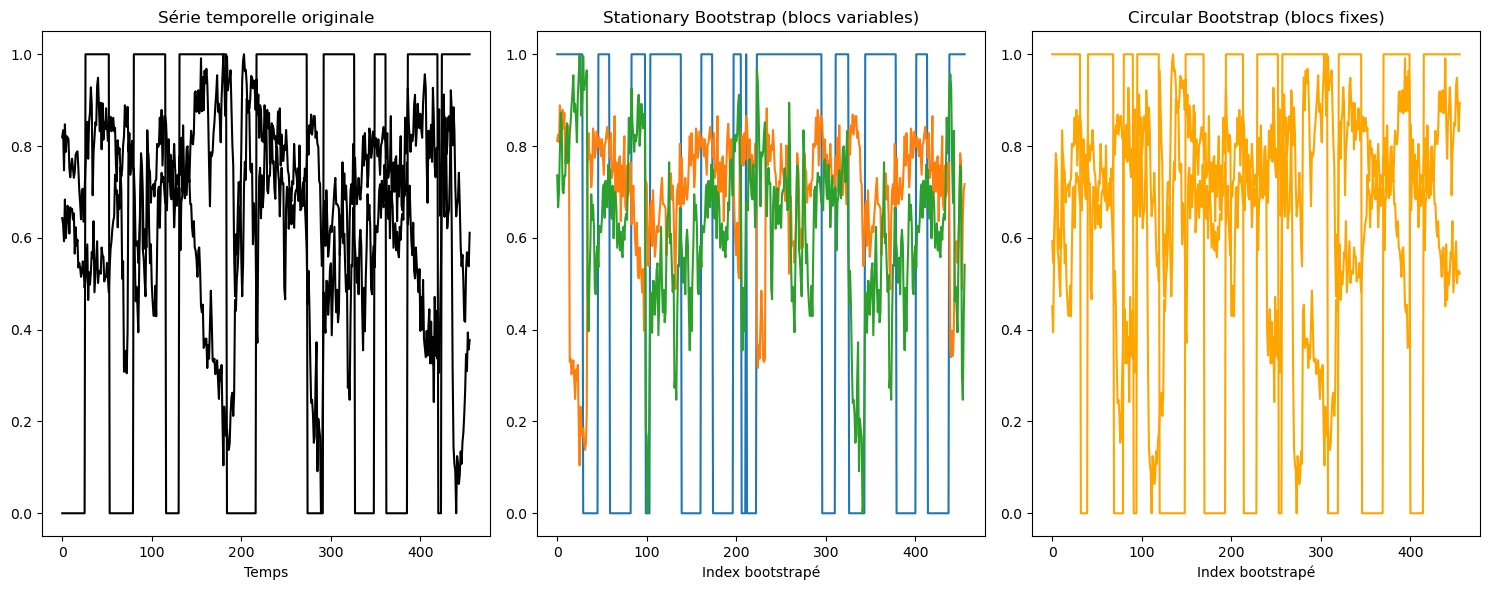

In [7]:
#création du dataframe test
y_last = tp.iloc[:,tp.shape[1]-1]
df = pd.concat([data, y_last], axis=1)

# Estimation des tailles optimales de bloc
opt_blocks = optimal_block_length(df)
b_sb = opt_blocks['stationary']  # taille moyenne pour StationaryBootstrap
b_cb = opt_blocks['circular']    # taille fixe pour CircularBlockBootstrap

print(f"Taille de bloc optimale pour StationaryBootstrap : {b_sb.iloc[0]:.2f}")
print(f"Taille de bloc optimale pour CircularBlockBootstrap : {b_cb.iloc[0]:.2f}")

# Création des objets bootstrap
sb = StationaryBootstrap(int(b_sb.iloc[0]), df)
cb = CircularBlockBootstrap(int(b_cb.iloc[0]), df)

# Générons un échantillon bootstrap pour visualiser
sample_sb = list(sb.bootstrap(1))[0][0][0]
sample_cb = list(cb.bootstrap(1))[0][0][0]

print(type(sample_sb))


# Supposons que 'target' est le nom de la colonne cible
target_col = '2022-12-15'

# Sélectionner 3 colonnes aléatoires parmi les autres (features)
random_features = random.sample([col for col in df.columns if col != target_col], 2)

# Colonnes à afficher = target + 3 variables choisies au hasard
cols_to_plot = [target_col] + random_features
# Visualisation
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(df[cols_to_plot].reset_index(drop=True), label="Données originales", color="black")
plt.title("Série temporelle originale")
plt.xlabel("Temps")

plt.subplot(1, 3, 2)
plt.plot(sample_sb[cols_to_plot].reset_index(drop=True), label="Stationary Bootstrap")
plt.title("Stationary Bootstrap (blocs variables)")
plt.xlabel("Index bootstrapé")

plt.subplot(1, 3, 3)
plt.plot(sample_cb[cols_to_plot].reset_index(drop=True), label="Circular Bootstrap", color='orange')
plt.title("Circular Bootstrap (blocs fixes)")
plt.xlabel("Index bootstrapé")

plt.tight_layout()
plt.show()



In [83]:
# Diviser en X (features) et y (cible)
X = np.arange(n).reshape(-1, 1)  # Juste l'indice comme feature
y = data

# Fonction de bootstrap par blocs
def block_bootstrap(data, block_size, n_bootstrap):
    n = len(data)
    bootstrap_samples = []
    for _ in range(n_bootstrap):
        sample = []
        while len(sample) < n:
            start = np.random.randint(0, n - block_size)
            sample.extend(data[start:start + block_size])
        sample = sample[:n]  # Ajuster la longueur de la série
        bootstrap_samples.append(np.array(sample))
    return np.array(bootstrap_samples)

# Appliquer le bootstrap par blocs
block_size = 10
n_bootstrap = 100  # Nombre d'échantillons bootstrap
bootstrap_samples = block_bootstrap(data, block_size, n_bootstrap)

# Entraîner XGBoost sur chaque échantillon bootstrap
models = []
for sample in bootstrap_samples:
    X_train, X_test, y_train, y_test = train_test_split(X, sample, test_size=0.2, shuffle=False)
    model = xgb.XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    models.append(model)

# Faire des prédictions avec les modèles bootstrap
predictions = np.mean([model.predict(X_test) for model in models], axis=0)

# Affichage des résultats
import matplotlib.pyplot as plt
plt.plot(y_test, label="True")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()


NameError: name 'n' is not defined